In [3]:
import random
import pandas as pd
import numpy as np
from itertools import accumulate, chain, compress, combinations
from tqdm import tqdm
import time

# Matlab functions translated to python:

def cell(rows, cols):
    """ Pre-allocate a 2D matrix of empty lists. """
    return [ [ [] for i in range(cols) ] for j in range(rows) ]

def randi(imax, size):
    if isinstance(size, int):
        return random.choices(range(imax), k=size)
    elif isinstance(size, tuple) or isinstance(size, list):
        cols = []
        for i in range(size[1]):
            cols.append(random.choices(range(1, imax+1), k=size[0]))
        mat = np.array(cols).T
        return mat
    else:
        print("Nothing")
        return None

def randperm(n, **kwargs):
    k = kwargs.get('k', n)
    return list(np.random.choice(range(n), size=k, replace=False))

def cumsum(list_):
    return list(accumulate(list_))

def poissrnd(lam, size):
    return list(np.random.poisson(lam, size) + 1)

def setdiff(A, B):
    return [item for item in A if not item in B]

def randsample(n,k,**kwargs):

    replacement = kwargs.get('repl', False)
    if k > n:
        replacement = True

    weights = kwargs.get('weights', None)

    # https://www.mathworks.com/help/stats/randsample.html#d124e839496
    # uses a vector of non-negative weights, w, whose length is n, 
    # to determine the probability that an integer i is selected as an entry for y.

    if weights:
        return random.choices(range(n), weights=weights, k=k)
    else:
        if replacement:
            return random.choices(range(n), k=k)
        else:
            return random.sample(range(n), n)

def rand(size_1, size_2):
    rand_ = np.random.uniform(low=0, high=1, size=(size_1, size_2))
    if size_2 == 1:
        rand_ = list(rand_.T[0])
    return rand_

def sort(array, dimension):

    if (dimension == 1) or (dimension == 2):

        if dimension == 1:
            array = array.T

        array_sorted = []
        for k in range(array.shape[0]):
            lst_append = list(array[k])
            lst_append.sort()
            array_sorted.append(lst_append)
        array_sorted = np.array(array_sorted)

        if dimension == 1:
            array_sorted = array_sorted.T

        return array_sorted

    else:
        return array

def histc(x, bins):
    if not isinstance(x, list):
        x = [x]
    x_fill = [0]*len(bins)
    x_idx = [0]*len(x)
    for idx, xx in enumerate(x):
        found = False
        for i in range(len(bins) - 1):
            if (xx >= bins[i]) and (xx < bins[i+1]) and not found:
                x_fill[i] = x_fill[i] + 1
                found = True
                x_idx[idx] = i + 1
    return x_fill, x_idx

# Custom Functions:

def readProbFile(file):
    xl = pd.ExcelFile(file)
    sheet_names = xl.sheet_names
    result = {}
    for sheet in sheet_names:
        df = pd.read_excel(file,
                        sheet_name=sheet, engine='openpyxl')
        df = df[[col for col in df.columns if not col.startswith('Unnamed')]]
        df = df.drop(columns=['Dias/E'])
        df['start'] = 0
        col_ = df.pop('start')
        df.insert(0, 'start', col_)
        result[sheet] = df.cumsum(axis=1).values
    return result

def setupFamilies(fileName):
    
    # read demographic data (located in the same directory)
    data = pd.read_csv(fileName)
    houses_county = data['Households'].tolist()
    age_group_01 = data['AG1'].tolist()
    people_county_0 = data['Population'].tolist()
    people_county = [0]*len(people_county_0)
    age_group_02 = data['AG2'].tolist()
    numCounties = data.shape[0] # number of counties
    numFam = sum(houses_county) # number of households

    # allocate arrays
    people_families = [0]*numFam # people per family
    people_age = []
    # create families based on Poisson distribution
    index = 0
    for j in range(numCounties):

        local_houses = houses_county[j]
        local_population = people_county_0[j]
        avrg_per_house = local_population/local_houses
        # create distribution for number of individuals per family
        number_people_per_house = list(np.random.poisson(avrg_per_house-1, local_houses) + 1)
        # store number of people per family
        adv = len(number_people_per_house)
        people_families[index: index + adv] = number_people_per_house
        index = index + adv
        # correct number of people per county (due to the random distribution)
        people_county[j] = sum(number_people_per_house)

        # include age groups
        n1 = int(np.floor(age_group_01[j]*people_county[j]))
        n2 = int(np.floor(age_group_02[j]*people_county[j]))
        n3 = people_county[j] - n1 - n2
        # create number of people per age labeled as 1, 2, 3
        age_groups = [1]*n1 + [2]*n2 + [3]*n3
        # sort age groups
        age_groups_perm = []
        perm_index = randperm(people_county[j])
        for index_2 in perm_index:
            age_groups_perm.append(age_groups[index_2])
        people_age.append(age_groups_perm)

    # accumulate sums for families and counties
    cumsum_people_per_family = [0] + cumsum(people_families)
    cumsum_people_per_county = [0] + cumsum(people_county)
    numIDs = int(cumsum_people_per_county[-1]) # total population
    # allocate arrays
    idToAge     = [0]*cumsum_people_per_family[-1]
    idToCounty  = [0]*cumsum_people_per_county[-1]
    countyToIDs = []
    idToFamily  = [0]*cumsum_people_per_family[-1]
    familyToIDs = []
    # fill idToCounty, idToAge, countyToIDs
    index = 0
    adv_total = 0
    for j in range(numCounties):
        range_ = range(cumsum_people_per_county[j], cumsum_people_per_county[j+1])
        for t in range_:
            idToCounty[t] = j
        countyToIDs.append(list(range_))
        adv = len(people_age[j])
        adv_total = adv_total + adv
        for k in range(index, index+adv):
            idToAge[k] = people_age[j][k - index]
        index = index + adv
    # fill idToFamily, familyToIDs
    for j in range(numFam):
        range_ = range(cumsum_people_per_family[j], cumsum_people_per_family[j+1])
        for t in range_:
            idToFamily[t] = j
        familyToIDs.append(list(range_))

    return numIDs, numFam, idToCounty, idToFamily, idToAge, familyToIDs, countyToIDs

nearCounties = pd.read_csv('./config_data/nearCounties.csv').values
minmaxBubble = pd.read_csv('./config_data/minmaxBubble.csv').values

## MainCall Test

In [5]:
T = 20
numCounties = 15
numInitExposed = 10
min_coworkers = 5
delta_coworkers = 10
min_sporadic  = 1
delta_sporadic  = 15

coefSpor = .5
coefFam = 1
p  = .21
pD = .13
pM = .07
pDM = 0.04
pO = .10 # % isolated O
coefMin = 0.5 #%0.012
print('Reading probability file')
acum = readProbFile('./config_data/prob.xlsx')
familyFILE = './config_data/setupFamily.csv'
pUseMask = .3
minDist  = 10

#  Data.
#  daily data (S, E, R: totals O, U, H, D: per age group)
totalS  = [1]*T
accumD1 = [1]*(T+1)
totalE  = [1]*T
accumD2 = [1]*(T+1)
totalR  = [1]*T
accumD3 = [1]*(T+1)
totalO1 = [1]*T
totalU1 = [1]*T
totalH1 = [1]*T
totalD1 = [1]*T
totalO2 = [1]*T
totalU2 = [1]*T
totalH2 = [1]*T
totalD2 = [1]*T
totalO3 = [1]*T
totalU3 = [1]*T
totalH3 = [1]*T
totalD3 = [1]*T
#  info per county
dataMap     = np.zeros((numCounties, T))
dataMapAcum = np.zeros((numCounties, T))
dataMapH    = np.zeros((numCounties, T))
dataMapDead = np.zeros((numCounties, T))
dataMapU    = np.zeros((numCounties, T))
#  2. Create household network
print('Creating household network')
[numIDs,numFam,idToCounty,idToFamily,idToAge,familyToIDs,countyToIDs] = setupFamilies(familyFILE)
#  keep track of...
familyAdded = [False]*numFam #  ... added families
notadded = [True]*numIDs     #  ... not added IDs
#  edge connectivity per layer
edges = cell(numIDs, 3)
#  number of contacts per ID: uniform value on [min, min+delta-1]
dgrLyr2 = [min_coworkers + value - 1 for value in randi(delta_coworkers, numIDs)]
dgrLyr3 = [min_sporadic + value - 1 for value in randi(delta_sporadic, numIDs)]
degrees = np.array([dgrLyr2, dgrLyr3]).T
#  list of possible contacts (to save time)
poolPeople = [[]]*numCounties #  lista de elegibles por cantón
for k in range(numCounties):
    counties_connected = list(np.where(nearCounties[k,:] > 0)[0])
    poolPeople[k] = list(chain.from_iterable([
        countyToIDs[county_index] for county_index in counties_connected]))

Reading probability file
Creating household network


In [ ]:
#  3. Initial conditions
#  states: 0-S 1-E 2-O 3-U 4-H 5-R 6-D
stateID  = [0]*numIDs
timeStateID = [0]*numIDs
#  numInitExposed initial exposed IDs
newExposedIDs = randi(numIDs, numInitExposed)
for k in newExposedIDs:
    stateID[k] = 1 #  S -> E
    timeStateID[k] = 1 #  on day 1

print('Daily iterations start -->')

#  4.
for day in range(T):

    print(f"Starting iteration for {day}")
    print(f'Number of new exposed ids: {len(newExposedIDs)}')

    #  update network: include contacts for new exposed people
    for j in range(len(newExposedIDs)):

        currID = newExposedIDs[j]  #  current ID
        numFamily = idToFamily[currID]

        if(not familyAdded[numFamily]): #  check if family has been added before
            familyNodes = familyToIDs[numFamily]  #  IDs for family
            nodesToAdd = list(compress(
                familyNodes, [notadded[k] for k in familyNodes]))
            for node in nodesToAdd:
                notadded[node] = False
            allEdges = list(combinations(familyNodes, 2))    #  family edges
            familyAdded[numFamily] = True                    #  mark family as added
            for m in range(len(allEdges)):
                #  update edges
                edges[allEdges[m][0]][0].append(allEdges[m][1])
                edges[allEdges[m][1]][0].append(allEdges[m][0])

        # for layer = 2:3
        layer = 1
        newConnections = int(max(0, degrees[currID][layer - 1] - len(edges[currID][layer])))

        if(newConnections > 0):

            #  who is eligible
            population = poolPeople[idToCounty[currID]]
            elegiblesW = [population[k] for k in randi(len(population), 3*newConnections)]
            elegiblesW = setdiff(elegiblesW, [currID] + edges[currID][0] + edges[currID][1] + edges[currID][2])
            newCoworkers = [elegiblesW[t] for t in
                randperm(len(elegiblesW), k_=min(newConnections, len(elegiblesW)))]
            #  find preexisting nodes on the graph
            nodesToAdd = list(compress(
                newCoworkers, [notadded[k] for k in newCoworkers]))
            #  update added
            for node in nodesToAdd:
                notadded[node] = False
            #  add edges
            allEdges = newCoworkers
            #  update neighbors
            for k in range(len(allEdges)):
                edges[currID][layer].append(allEdges[k]) # end+1 in matlab is equivalent to append in python

            for m in range(len(allEdges)):
                edges[allEdges[m]][layer].append(currID)

    layer = 2
    vector = list(np.where((np.array(stateID) == 2)|(np.array(stateID) == 3))[0]) # find()
    for j in range(numIDs):
        edges[j][layer] = []

    for currID in vector:

        newConnections = degrees[currID][layer-1]
        population = poolPeople[idToCounty[currID]]
        elegiblesW = [population[k] for k in randi(len(population), 2*int(newConnections))]
        teem = [currID] + edges[currID][0] + edges[currID][1] + edges[currID][2]
        elegiblesW = setdiff(elegiblesW, teem)
        newCoworkers = [elegiblesW[t] for t in 
                        randperm(len(elegiblesW), k=min(len(elegiblesW),newConnections))]
        #  find preexisting nodes on the graph
        nodesToAdd = list(compress(
                newCoworkers, [notadded[k] for k in newCoworkers]))
        #  update added
        for node in nodesToAdd:
            notadded[node] = False
        #  add edges
        allEdges = newCoworkers
        #  update neighbors
        edges[currID][layer] = allEdges
        for m in range(len(allEdges)):
            edges[allEdges[m]][layer].append(currID)

    #  probability of infection: state 2, 3, 4 can infect their contacts
    newExposedIDs = []   #  restart list of new E
    indexStoE = list(np.where((np.array(stateID) == 2)|(np.array(stateID) == 3)|(np.array(stateID) == 4))[0])
    StoE = []
    for i in range(3):
        for index in indexStoE:
            StoE = StoE + edges[index][i]
    StoE = list(set(StoE))
    print(f'StoE of this iter: {StoE}')

    #  set daily #  mask and social distancing
    if (day==20): #  strict measures on day 20
        pUseMask = .9
        minDist  = .7
        minmaxBubble = randi(5, (numCounties, 2))
        minmaxBubble = sort(minmaxBubble, 2)

    if (day==80):  #  release measures on day 80
        pUseMask = .7
        minDist  = .3
        minmaxBubble = randi(15, (numCounties, 2))
        minmaxBubble = sort(minmaxBubble, 2)

    useMask  = randsample(2, numIDs, repl=True, weights=[1-pUseMask, pUseMask])
    puse_vals = rand(numCounties,1)
    pUseDist = [(minDist + 10*puse_val)/100 for puse_val in puse_vals]

    for currID in StoE:

        if (stateID[currID] == 0):  #  check susceptibles

            numCounty  = idToCounty[currID]
            sizeBubble = random.randrange(minmaxBubble[numCounty, 0], minmaxBubble[numCounty, 1] + 1)
            chosenN1 = edges[currID][1]
            chosenN2 = edges[currID][2]

            if (len(chosenN1)+len(chosenN2) > sizeBubble):

                print(sizeBubble)
                nN = randi(sizeBubble,1)
                nN1 = min(nN, len(chosenN1))
                nN2 = min(sizeBubble - nN1, len(chosenN2))

                while(nN1+nN2<sizeBubble):

                    if(nN1 < len(chosenN1)):
                        nN1 = nN1 + 1

                    if(nN2 < len(chosenN2)):
                        nN2 = nN2 + 1

                idx1 = randsample(len(chosenN1), nN1)
                idx2 = randsample(len(chosenN2), nN2)

                chosenN1 = [chosenN1[k] for k in idx1]
                chosenN2 = [chosenN2[k] for k in idx2]

            #  distribution for people that use mask and apply social distancing
            useMask1 = [useMask[k] + 1 for k in chosenN1]
            useMask2 = [useMask[k] + 1 for k in chosenN2]

            _, useDist1 = histc(rand(len(chosenN1),1), [0, 1 - pUseDist[numCounty], 1])
            _, useDist2 = histc(rand(len(chosenN2),1), [0, 1 - pUseDist[numCounty], 1])

            #  0-S 1-E 2-O 3-U 4-H 5-R 6-D
            states = [stateID[k] for k in edges[currID][0]] # layer 1
            iu = [state == 3 for state in states]
            id = [state == 2 or state == 4 for state in states]

            p1 = sum(iu) + pO*sum(id)
            risk = (1-coefFam*p)**(coefMin*p1)

            states = [stateID[k] for k in chosenN1] #  layer 2
            iu = [state == 3 for state in states]
            id = [state == 2 or state == 4 for state in states]

            for k in range(len(iu)):
                if iu[k]:
                    if (useMask1[k]==2 and useDist1[k]==2):
                        risk = risk*((1-pDM)**coefMin)
                    elif(useMask1[k]==2 and useDist1[k]==1):
                        risk = risk*((1-pM)**coefMin)
                    elif(useMask1[k]==1 and useDist1[k]==2):
                        risk = risk*((1-pD)**coefMin)
                    else:
                        risk = risk*((1-p)**coefMin)

            for k in range(len(id)):
                if id[k]:
                    if(useMask1[k]==2 and useDist1[k]==2):
                        risk = risk*((1-pDM)**(coefMin*pO))
                    elif(useMask1[k]==2 and useDist1[k]==1):
                        risk = risk*((1-pM)**(coefMin*pO))
                    elif(useMask1[k]==1 and useDist1[k]==2):
                        risk = risk*((1-pD)**(coefMin*pO))
                    else:
                        risk = risk*((1-p)**(coefMin*pO))

            states = [stateID[k] for k in chosenN2] #  layer 3
            iu = [state == 3 for state in states]
            id = [state == 2 or state == 4 for state in states]

            for k in range(len(iu)):
                if iu[k]:
                    if(useMask2[k]==2 and useDist2[k]==2):
                        risk = risk*((1-coefSpor*pDM)**coefMin)
                    elif(useMask2[k]==2 and useDist2[k]==1):
                        risk = risk*((1-coefSpor*pM)**coefMin)
                    elif(useMask2[k]==1 and useDist2[k]==2):
                        risk = risk*((1-coefSpor*pD)**coefMin)
                    else:
                        risk = risk*((1-coefSpor*p)**coefMin)

            for k in range(len(id)):
                if id[k]:
                    if(useMask2[k]==2 and useDist2[k]==2):
                        risk = risk*((1-coefSpor*pDM)**(coefMin*pO))
                    elif(useMask2[k]==2 and useDist2[k]==1):
                        risk = risk*((1-coefSpor*pM)**(coefMin*pO))
                    elif(useMask2[k]==1 and useDist2[k]==2):
                        risk = risk*((1-coefSpor*pD)**(coefMin*pO))
                    else:
                        risk = risk*((1-coefSpor*p)**(coefMin*pO))

            risk = 1 - risk #  probability infection
            rand_num = np.random.uniform(low=0, high=1, size=1)[0]
            if rand_num < risk:
                newExposedIDs.append(currID) # #ok<*AGROW>

    #  transitions
    for k in newExposedIDs:
        timeStateID[k] = day #  first mark S->E
        stateID[k] = 1

    elegible = list(np.where((np.array(stateID) > 0) & (np.array(stateID) < 5 ))[0]) #find(stateID>0 & stateID<5) #  all transitions but S->E
    states = [stateID[k] for k in elegible] #  all states
    indexD = []                           #  store new cases for accum data
    print(f'elegible: {len(elegible)}')
    for j in range(len(states)):

        state = states[j]
        ID = elegible[j]
        time = day - timeStateID[ID]

        if state == 1:
            
            # Up to here:
            _ , event = histc(np.random.uniform(low=0, high=1, size=1)[0], acum['E'][(time+1),:]) # #ok<*HISTC>
            event = event[0]

            if (event != 1):
                stateID[ID] = event
                timeStateID[ID] = day

            if (event == 2): #  observed case
                indexD = indexD + [ID]

        elif state == 2:

            time = day - timeStateID[ID]
            age  = idToAge[ID]
            if age == 1:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0], acum['D1'][(time+1),:])
            elif age == 2:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['D2'][(time+1),:])
            elif age == 3:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['D3'][(time+1),:])
            event = event[0]
            
            if (event != 2):
                stateID[ID] = event
                timeStateID[ID] = day

        elif state == 3:

            time = day - timeStateID[ID]
            _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['U'][(time+1),:])
            event = event[0]
            
            if (event != 3):
                stateID[ID] = event
                timeStateID[ID] = day

        elif state == 4:

            time = day - timeStateID[ID]
            age  = idToAge[ID]

            if age == 1:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['HE1'][(time+1),:])
            elif age == 2:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['HE2'][(time+1),:])
            elif age == 3:
                _, event = histc(np.random.uniform(low=0, high=1, size=1)[0],acum['HE3'][(time+1),:])
            event = event[0]    
            
            if(event != 4):
                stateID[ID] = event
                timeStateID[ID] = day

    #  save data
    iss = [state == 0 for state in stateID]
    ie = [state == 1 for state in stateID]
    io = [state == 2 for state in stateID]
    iu = [state == 3 for state in stateID]
    ih = [state == 4 for state in stateID]
    ir = [state == 5 for state in stateID]
    id = [state == 6 for state in stateID]

    accumD1[day+1] = accumD1[day] + sum([idToAge[k]==1 for k in indexD])
    accumD2[day+1] = accumD2[day] + sum([idToAge[k]==2 for k in indexD])
    accumD3[day+1] = accumD3[day] + sum([idToAge[k]==3 for k in indexD])
    totalS[day] = sum(iss) 
    totalE[day] = sum(ie) 
    totalR[day] = sum(ir)
    # info according age groups

    ii = [idAge == 1 for idAge in idToAge] # (idToAge==1)
    totalU1[day] = sum([iu[k] and ii[k] for k in range(len(stateID))])
    totalO1[day] = sum([io[k] and ii[k] for k in range(len(stateID))])
    totalH1[day] = sum([ih[k] and ii[k] for k in range(len(stateID))])
    totalD1[day] = sum([id[k] and ii[k] for k in range(len(stateID))])

    ii = [idAge == 2 for idAge in idToAge] # (idToAge==2)
    totalU2[day] = sum([iu[k] and ii[k] for k in range(len(stateID))])
    totalO2[day] = sum([io[k] and ii[k] for k in range(len(stateID))])
    totalH2[day] = sum([ih[k] and ii[k] for k in range(len(stateID))])
    totalD2[day] = sum([id[k] and ii[k] for k in range(len(stateID))])

    ii = [idAge == 3 for idAge in idToAge] # (idToAge==3)
    totalU3[day] = sum([iu[k] and ii[k] for k in range(len(stateID))])
    totalO3[day] = sum([io[k] and ii[k] for k in range(len(stateID))])
    totalH3[day] = sum([ih[k] and ii[k] for k in range(len(stateID))])
    totalD3[day] = sum([id[k] and ii[k] for k in range(len(stateID))])

    # save info per county
    ids_county_io = [idToCounty[k] for k in range(len(io)) if io[k]]
    ids_county_ih = [idToCounty[k] for k in range(len(ih)) if ih[k]]
    ids_county_iu = [idToCounty[k] for k in range(len(iu)) if iu[k]]
    ids_county_id = [idToCounty[k] for k in range(len(id)) if id[k]]
    ids_county = [idToCounty[indexD[t]] for t in range(len(indexD))]

    for k in range(numCounties):
        dataMap[k, day] = len([id_ for id_ in ids_county_io if id_ == k])
        dataMapH[k, day] = len([id_ for id_ in ids_county_ih if id_ == k])
        dataMapU[k, day] = len([id_ for id_ in ids_county_iu if id_ == k])
        dataMapDead[k, day] = len([id_ for id_ in ids_county_id if id_ == k])
        dataMapAcum[k, day] = dataMapAcum[k, day] + len([id_ for id_ in 
                                                         ids_county if id_ == k])


### Creating reduced family file for examples:

In [6]:
data = pd.read_csv('./config_data/setupFamily.csv')
data['Households_per_Pop'] = data['Households']/data['Population']
data

,County,Households,Population,AG1,AG2,AG3,MinContacts,MaxContacts,Households_per_Pop
0,1,5719,20000,0.310352,0.597972,0.091677,5,15,0.285950
1,2,6279,21200,0.261376,0.649026,0.089598,3,13,0.296179
2,3,9448,33069,0.297832,0.630833,0.071336,1,10,0.285706
3,4,89774,314209,0.279238,0.631023,0.089740,1,10,0.285714
4,5,27014,94548,0.312688,0.616819,0.070493,5,15,0.285717
5,6,4409,25433,0.292620,0.623340,0.084041,3,13,0.173357
6,7,18151,63529,0.285082,0.636339,0.078578,1,10,0.285712
7,8,8383,34240,0.259100,0.623108,0.117791,1,10,0.244831
8,9,6894,24130,0.335723,0.585329,0.078947,5,15,0.285702
9,10,13429,47002,0.283371,0.628143,0.088486,3,13,0.285711


In [7]:
data['Population'] = ((1/100)*data['Population']).astype(int)
data['Households'] = data['Households_per_Pop']*data['Population']
data['Households'] = data['Households'].astype(int)
data = data.drop(columns=['Households_per_Pop'])
data

,County,Households,Population,AG1,AG2,AG3,MinContacts,MaxContacts
0,1,57,200,0.310352,0.597972,0.091677,5,15
1,2,62,212,0.261376,0.649026,0.089598,3,13
2,3,94,330,0.297832,0.630833,0.071336,1,10
3,4,897,3142,0.279238,0.631023,0.089740,1,10
4,5,270,945,0.312688,0.616819,0.070493,5,15
5,6,44,254,0.292620,0.623340,0.084041,3,13
6,7,181,635,0.285082,0.636339,0.078578,1,10
7,8,83,342,0.259100,0.623108,0.117791,1,10
8,9,68,241,0.335723,0.585329,0.078947,5,15
9,10,134,470,0.283371,0.628143,0.088486,3,13


In [8]:
data.to_csv('./config_data/setupFamily_reduced.csv')

#### Plot figure:

In [1]:
import matplotlib.pyplot as plt

# Testing SE(O,U,H)R model

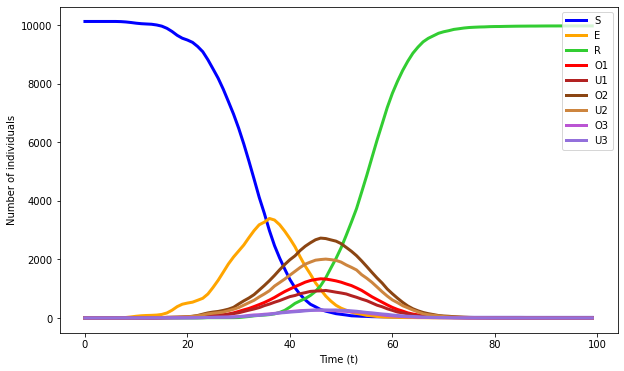

In [19]:
results_data = pd.read_csv('././results/model_results_sim_0.csv')
t = range(results_data.shape[0])
plt.plot(t, results_data['totalS'], label='S', color='blue', linewidth=3)
plt.plot(t, results_data['totalE'], label='E', color='orange', linewidth=3)
plt.plot(t, results_data['totalR'], label='R', color='limegreen', linewidth=3)
plt.plot(t, results_data['totalO1'], label='O1', color='red', linewidth=3)
plt.plot(t, results_data['totalU1'], label='U1', color='firebrick', linewidth=3)
plt.plot(t, results_data['totalO2'], label='O2', color='saddlebrown', linewidth=3)
plt.plot(t, results_data['totalU2'], label='U2', color='peru', linewidth=3)
plt.plot(t, results_data['totalO3'], label='O3', color='mediumorchid', linewidth=3)
plt.plot(t, results_data['totalU3'], label='U3', color='mediumpurple', linewidth=3)
plt.xlabel("Time (t)")
plt.ylabel("Number of individuals")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

# Testing only SEIR model:

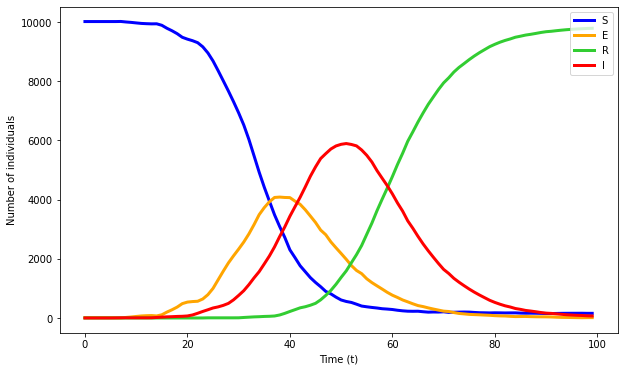

In [20]:
results_data = pd.read_csv('././results/model_results_sim_0SEIR.csv')
t = range(results_data.shape[0])
plt.plot(t, results_data['totalS'], label='S', color='blue', linewidth=3)
plt.plot(t, results_data['totalE'], label='E', color='orange', linewidth=3)
plt.plot(t, results_data['totalR'], label='R', color='limegreen', linewidth=3)
plt.plot(t, results_data['totalI'], label='I', color='red', linewidth=3)
plt.xlabel("Time (t)")
plt.ylabel("Number of individuals")
plt.legend(loc="upper right")
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

## Set up optimal contacts and curvatures:

In [175]:
idToOptimal, idToCurvature = setup_optimal_contacts(minmaxBubble, countyToIDs, numIDs)

In [173]:
def setup_optimal_contacts(minmaxBubble, countyToIDs, numIDs):

    """
    This creates an assignment of contact behaviour specs for each node.
    id | optimal_coworker_contacts | willingness_to_change
    .  | ....                      | ....

    willingness_to_change: parameter that will control the utility function curvature.
    optimal_coworkwer_contacts: utility function optimal point (decision purely economical).

    function returns two vectors:

    idToOptimalCts  <- an optimal contact number for each individual in the population. 
    idToCurvature <- a utility function curvature parameter for each individual in the population.

    Algorithm proposed:
    - Contacts selected by individuals are restricted to county limits.
    We use three types of populations within a county:
        1. People with high optimal contact requirements ---> They have a optimal contacts in the upper quartile of the county allowed contact range.
        2. People with middle optimal contact requirements ---> They have a optimal contacts between q25 and q75 of the county allowed contact range.
        3. People with low optimal contact requirements ---> They have a optimal contacts in the lower quartile of the county allowed contact range.

    We set a proportion of high contact individuals:  p_high_contact
    We set a proportion of middle contact individuals:  p_middle_contact
    We set a proportion of low contact individuals:  p_low_contact

    We also must set a utility function curvature for each individual.
    There are two types of individuals with this specs:
        1. Individuals with high curvature (less willing to change contacts in view of disease).
        2. Individuals with low curvature (more willing to change contacts in view of disease).
    
    For each county:

        contact_range_county = range(minmaxBubble[county][0], minmaxBubble[county][1])
        
        # High contacts:
        random sample p_high_contact individuals of the county assign them a contact number in the upper q75 of contact_range_county
        for those, assign a proportion p_high_curvature_high_contact with high curvature and a proportion p_low_curvature_high_contact with low curvature.

        # Middle contacts:
        random sample p_middle_contact individuals of the county that are left and assign them a contact number in the upper q75 of contact_range_county
        for those, assign a proportion p_middle_curvature_middle_contact with middle curvature and a proportion p_low_curvature_middle_contact with low curvature.

        # Low contacts:
        random sample p_low_contact individuals of the county that are left and assign them a contact number in the upper q75 of contact_range_county
        for those, assign a proportion p_low_curvature_low_contact with low curvature and a proportion p_low_curvature_low_contact with low curvature.

        Add these specs to idToOptimal and idToCurvature

    return idToOptimal, idToCurvature

    Note that only the susceptible individuals make an adaptive decision process here.
    (we are back to the non-relapse case, for simplicity). This will be only for susceptibles.

    """

    idToOptimal = [0]*numIDs
    idToCurvature = ['']*numIDs

    for county_idx in range(len(countyToIDs)):

        contact_range_county = range(minmaxBubble[county_idx][0], minmaxBubble[county_idx][1] + 1)
        q25 = int(np.quantile(contact_range_county, 0.25))
        q75 = int(np.quantile(contact_range_county, 0.75))
        min_county, max_county = minmaxBubble[county_idx][0], minmaxBubble[county_idx][1]
        countyPop = countyToIDs[county_idx]

        p_high_contact = 0.2
        p_high_curvature_high_contact = 0.05
        p_low_curvature_high_contact = 0.95

        p_middle_contact = 0.5
        p_high_curvature_middle_contact = 0.05
        p_low_curvature_middle_contact = 0.95

        # p_low_contact = 1 - p_high_contact - p_middle_contact
        p_high_curvature_low_contact = 0.05
        p_low_curvature_low_contact = 9.95

        probs_curvatures = [
            (p_high_curvature_high_contact, p_low_curvature_high_contact),
            (p_high_curvature_middle_contact, p_low_curvature_middle_contact),
            (p_high_curvature_low_contact, p_low_curvature_low_contact)
        ]

        countyPop_shuffled = random.sample(countyPop, len(countyPop))

        size_high_contact = int(p_high_contact*len(countyPop))
        size_middle_contact = int(p_middle_contact*len(countyPop))
        # size_low_contact = len(countyPop) - size_high_contact - size_middle_contact

        groups = [countyPop_shuffled[0: size_high_contact],
                countyPop_shuffled[size_high_contact: size_high_contact + size_middle_contact],
                countyPop_shuffled[size_high_contact + size_middle_contact: len(countyPop_shuffled)]]

        all_groups_split = []

        for idx, group in enumerate(groups):
            size_high_curvature = int(probs_curvatures[idx][0]*len(group))
            # size_low_curvature = len(group) - size_high_curvature
            group_split = [group[0: size_high_curvature], group[size_high_curvature: len(group)]]
            all_groups_split.append(group_split)

        indv_labels = []
        for idx, group_split in enumerate(all_groups_split):
            if idx == 0:
                opt_ct = int(random.randint(q75, max_county))
            elif idx == 1:
                opt_ct = int(random.randint(q25, q75))
            else:
                opt_ct = int(random.randint(min_county, q25))
                
            for idd in group_split[0]:
                indv_labels.append((idd, opt_ct, 'high'))
            for idd in group_split[1]:
                indv_labels.append((idd, opt_ct, 'low'))

        for i in range(len(indv_labels)):
            idx_use = indv_labels[i][0]
            idToOptimal[idx_use] = indv_labels[i][1]
            idToCurvature[idx_use] = indv_labels[i][2]

    return idToOptimal, idToCurvature

## Obtain adaptive contact decision

In [170]:
# TODO